In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import chess
from sarfa import core, BoardVisualization, SarfaBaseline, Engine, RemovalPerturber, SarfaComputeResult, get_all_pos
from IPython.display import Image, display
from collections import defaultdict

# Visualization Testing

Testing the visualization code is working

In [3]:
# FEN = '6k1/2n1b1r1/r1q1p1p1/2p1PpNp/1pP2P1P/pP1RB3/P2Q2P1/3R2K1 w - - 0 1'
FEN = "3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1"
action = ''
RUNTIME=2.0

In [4]:
board = chess.Board(FEN)
engine = Engine("./stockfish_15_x64_avx2")
board_visualization = BoardVisualization(board)


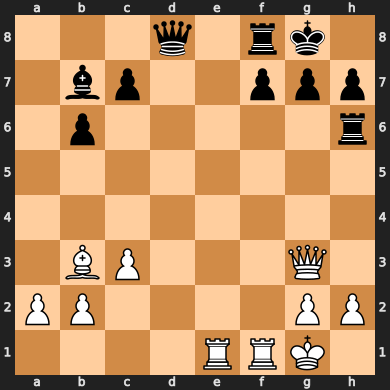

In [5]:
board_visualization.only_board()

# Sarfa (without defined action)


Ensuring that the optimal action is chosen when no other action has been officially inputted

In [6]:
saliency_results: dict[str, float] = defaultdict(int)
perturber = RemovalPerturber(board)
saliency_calculator = SarfaBaseline(engine, board)
for perturbed_board, perturbed_position_str in perturber.process():

    sarfa_compute_result: SarfaComputeResult = saliency_calculator.compute(perturbed_board, None)
    saliency_results[perturbed_position_str] = sarfa_compute_result.saliency
    print(f"{perturbed_position_str} removed: {sarfa_compute_result.saliency}")

a2 removed: 0.5759680157799453
b2 removed: 0.050978914569053124
b3 removed: 0.6966070577636598
b6 removed: 0.015007198573058239
b7 removed: 0.6563694370245502
c3 removed: 0.9950749673642644
c7 removed: 0.7303728153631066
d8 removed: 0.0358130593265831
e1 removed: 0.7668185987249733
f1 removed: 0.39761051236173167
f7 removed: 0
f8 removed: 0.08129736874886855
g2 removed: 0.3715151255989306
g3 removed: 0.572333609351278
g7 removed: 0
h2 removed: 0.9919642450403038
h6 removed: 0.0572711626711018
h7 removed: 0.6519815149540785


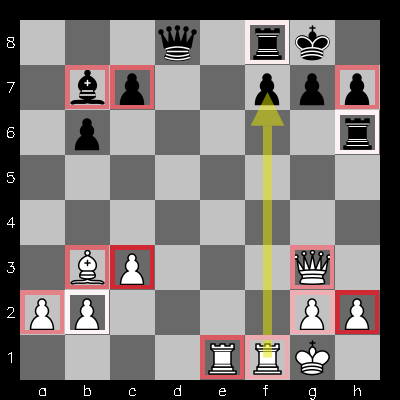

In [7]:
path = board_visualization.show_heatmap(saliency_results, chess.Move.from_uci(sarfa_compute_result.optimal_move))
display(Image(path))

# Sarfa Baseline with Move

When move is inputted, the first move is always going to be that selected move.

In [8]:
board = chess.Board("3q2k1/1bp2rpp/1p5r/8/8/1BP3Q1/PP4PP/4R1K1 w - - 0 2")
board_visualization = BoardVisualization(board)
action: chess.Move = chess.Move.from_uci("g3c7")

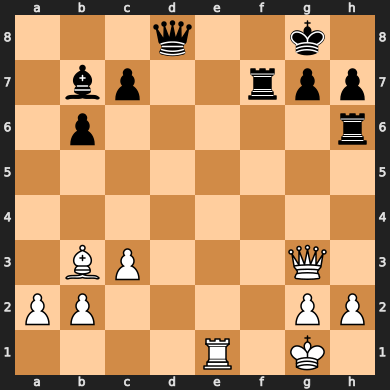

In [9]:
board_visualization.only_board()

In [10]:
saliency_results: dict[str, float] = defaultdict(int)
perturber = RemovalPerturber(board)
saliency_calculator = SarfaBaseline(engine, board, runtime=2)
for perturbed_board, perturbed_position_str in perturber.process():

    sarfa_compute_result: SarfaComputeResult = saliency_calculator.compute(perturbed_board, action)
    saliency_results[perturbed_position_str] = sarfa_compute_result.saliency
    print(f"{perturbed_position_str} removed: {sarfa_compute_result.saliency} \t {sarfa_compute_result}")


a2 removed: 0 	 SarfaComputeResult(saliency=0, dP=-5.55969988857985e-06, optimal_move='g3c7', optimal_move_q_val=8.3)
b2 removed: 0 	 SarfaComputeResult(saliency=0, dP=-7.358963232340088e-06, optimal_move='g3c7', optimal_move_q_val=8.3)
b3 removed: 0.10313780124335077 	 SarfaComputeResult(saliency=0.10313780124335077, dP=0.999988364831012, optimal_move='g3c7', optimal_move_q_val=8.3)
b6 removed: 1.1711722904012618e-05 	 SarfaComputeResult(saliency=1.1711722904012618e-05, dP=5.85591919644024e-06, optimal_move='g3c7', optimal_move_q_val=8.3)
b7 removed: 0 	 SarfaComputeResult(saliency=0, dP=-1.3611062524954143e-05, optimal_move='g3c7', optimal_move_q_val=8.3)
c3 removed: 0.7268755942080805 	 SarfaComputeResult(saliency=0.7268755942080805, dP=0.9999864674484693, optimal_move='g3c7', optimal_move_q_val=8.3)
c7 removed: 0.01611341185600278 	 SarfaComputeResult(saliency=0.01611341185600278, dP=0.008471766670341774, optimal_move='g3c7', optimal_move_q_val=8.3)
d8 removed: 0.05668376604727375 

In [11]:
perturbed_board.was_into_check()

False

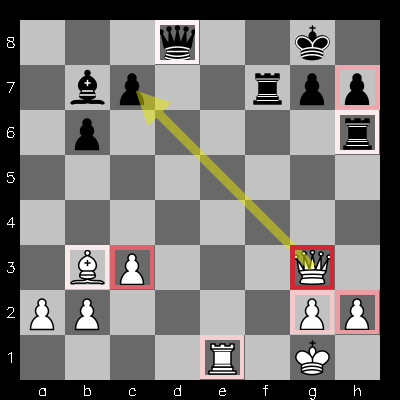

In [12]:
path = board_visualization.show_heatmap(saliency_results, action)
display(Image(path))

# Benchmarking

In [13]:
from chess_dataset import SarfaBenchmark
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## Settings

In [15]:
RUNTIME=2.0
name = f"sarfa_baseline_{int(RUNTIME * 10)}"
name

'sarfa_baseline_20'

In [17]:
def saliency_algorithm(fen, action=None) -> dict[str, float]:
    board = chess.Board(fen)

    saliency_results: dict[str, float] = defaultdict(int)
    perturber = RemovalPerturber(board)
    saliency_calculator = SarfaBaseline(engine, board, runtime=RUNTIME)
    for perturbed_board, perturbed_position_str in perturber.process():
        saliency_result = saliency_calculator.compute(perturbed_board, 
        action)
        saliency_results[perturbed_position_str] = saliency_result.saliency

    return saliency_results


In [18]:
benchmark = SarfaBenchmark.run(saliency_algorithm, name, sanity_check=True)

2r2rk1/pp1bqpp1/2nppn1p/2p3N1/1bP5/1PN3P1/PBQPPPBP/3R1RK1 w - - 0 1
r2qrbk1/1bp2ppp/p2p1n2/2p2NB1/4P3/2N2Q2/PPP2PPP/R3R1K1 w - - 0 1
2r4k/3r1p1p/1p2pP2/p2pPp1P/P2P1Q2/6R1/4B1PK/2q5 w - - 0 1
R4rk1/5bb1/1N1Qpq1p/3pn1p1/3N4/2P2P1P/P5P1/5B1K w - - 0 1
5r1k/bp4pp/1n6/5qN1/1PR5/P2Q3P/5PP1/6K1 w - - 0 1


In [23]:
benchmark.accuracy()

{'accuracy - harmonic_mean': 0.7902174632702069}

# Loading

In [19]:
sarfa_benchmark = SarfaBenchmark.load_results(saliency_algorithm, "sarfa_baseline_20")

In [20]:
sarfa_benchmark.accuracy()

{'accuracy - harmonic_mean': 0.7993333176970103}

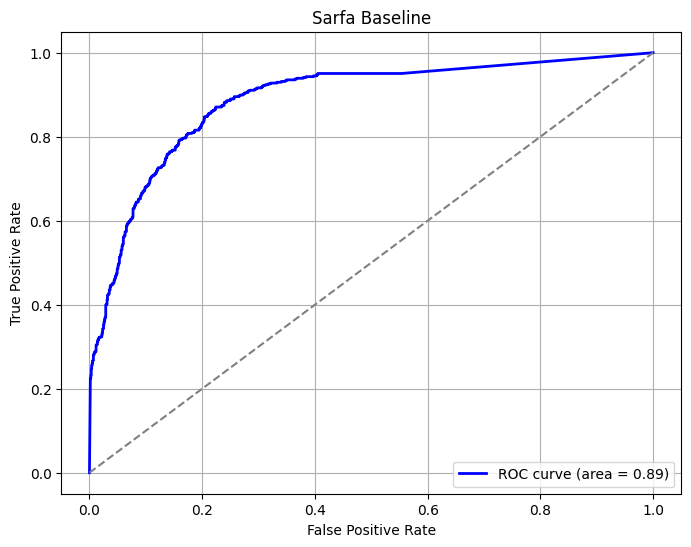

In [21]:
sarfa_benchmark.plot_roc("Sarfa Baseline")

## Specific Case Testing

Template workspace for testing a specific FEN and how the algorithm performs

In [22]:
FEN = "3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1"
board = chess.Board(FEN)

board_visualizer = BoardVisualization(board)

legal_moves = list(board.legal_moves)
_, optimal_move = engine.q_values(chess.Board(FEN), legal_moves, multipv=len(legal_moves), runtime=2.0)

saliency_results = saliency_algorithm(FEN)


board_visualizer.show_heatmap(saliency_results, chess.Move.from_uci(optimal_move))

'svg_custom/board.png'

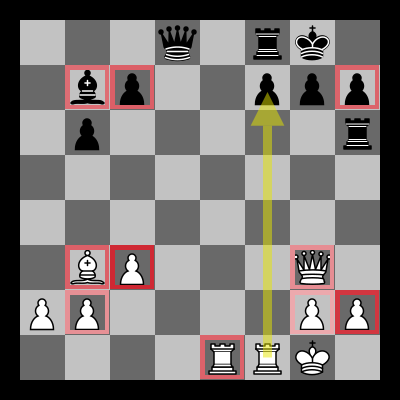

In [ ]:
display(Image('svg_custom/board.png'))